Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Launching the GenAI Baseball Demo in Colab or Vertex AI Workbench

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/DHHHG/GenAI-Baseball-Demo/blob/main/GenAI_Baseball_Demo_2024.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/DHHHG/GenAI-Baseball-Demo/blob/main/GenAI_Baseball_Demo_2024.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/DHHHG/GenAI-Baseball-Demo/main/GenAI_Baseball_Demo_2024.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


In [1]:
# @title ##Install Required Packages and Restart if Google Colab

!pip install google-cloud-aiplatform pybaseball gradio typing-extensions==4.5 pydantic-core==0.42 matplotlib --upgrade

# # Automatically restart Colab kernel after installs so that your environment can access the new packages
import IPython, sys

if "google.colab" in sys.modules:
  app = IPython.Application.instance()
  app.kernel.do_shutdown(True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 27.6 MB/

In [1]:
# @title ##(Google Colab Only) Authenticate with GCP Credentials

import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

In [2]:
# @title ##Setup Vertex AI with Gemini Pro
import vertexai
from vertexai.preview import generative_models
from vertexai.preview.generative_models import GenerativeModel, Part

PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
model_name = "gemini-pro" # @param ["gemini-pro"]
LOCATION = "us-central1"  # @param ["us-central1", "us-east1", "us-east4", "us-east5", "us-west1", "us-west2", "us-west3", "us-west4", "us-south1"]
vertexai.init(project=PROJECT_ID, location=LOCATION)

max_output_tokens_val = 8192  # @param {type:"integer"}
temperature_val = 0.8 # @param {type:"number"}
top_k_val = 40 # @param {type:"integer"}
top_p_val = 1 # @param {type:"number"}

# Safety config
safety_config = {
      generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_NONE,
      generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_NONE,
      generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_NONE,
      generative_models.HarmCategory.HARM_CATEGORY_UNSPECIFIED: generative_models.HarmBlockThreshold.BLOCK_NONE,
      generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_NONE,
    }

def generate(prompt,max_output_tokens=max_output_tokens_val,temperature=temperature_val,top_p=top_p_val,top_k=top_k_val,safety_config=safety_config):
  model = GenerativeModel(model_name)
  responses = model.generate_content(
    prompt,
    generation_config={
        "max_output_tokens": max_output_tokens,
        "temperature": temperature,
        "top_p": top_p,
        "top_k": top_k,
    },
    stream=True,
    safety_settings=safety_config,
  )

  text_responses = []
  for response in responses:
      #print(response.text)
      text_responses.append(response.text)
  return "".join(text_responses)

Gathering Player Data


/usr/local/lib/python3.10/dist-packages/pybaseball/plotting.py:138: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]


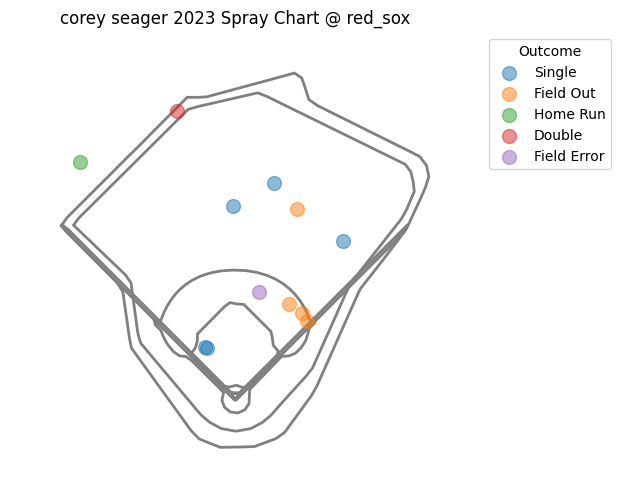

<Axes: title={'center': 'corey seager 2023 Spray Chart @ red_sox'}>

In [4]:
# @title ## Basics: pybaseball Spray Chart

from pybaseball import statcast_batter, spraychart, cache, playerid_lookup

cache.enable()
season = 2023 # @param {type:"integer"}
player_name = "Corey Seager" # @param {type:"string"}
home_team = "BOS" # @param ["HOU", "LAA", "ATL", "BAL", "BOS", "LAD", "OAK", "MIA", "MIL", "MIN", "SFG", "TBR", "CIN", "CLV", "CSW", "STL", "SEA", "TEX", "WSN", "NYY", "NYM", "PHI", "SDP", "CHC", "PIT", "TOR", "DET", "KCR", "ARI"]
stadium ="red_sox" # @param ["angels", "astros", "athletics", "blue_jays", "braves", "brewers", "cardinals", "cubs", "diamondbacks", "dodgers", "generic", "giants", "indians", "mariners", "marlins", "mets", "nationals", "orioles", "padres", "phillies", "pirates", "rangers", "rays", "red_sox", "reds", "rockies", "royals", "tigers", "twins", "white_sox", "yankees"]

first, last = player_name.split(" ")
player_id_df = playerid_lookup(last, first, fuzzy=True)
first_name = player_id_df['name_first'][0]
last_name = player_id_df['name_last'][0]
player_name = first_name + " " + last_name
player_id = player_id_df['key_mlbam'][0]

title = (player_name + " " + str(season) + " Spray Chart @ " + stadium)

data = statcast_batter(str(season) + '-04-01', str(season) + '-10-01', player_id)
sub_data = data[data['home_team'] == home_team]
spraychart(sub_data, stadium, title=title)

In [5]:
# @title ##Test Gemini Pro: Generate Code
code_prompt = "Provide only the python code to display a bar chart?" # @param {type:"string"}
code_output = generate(code_prompt)
print(code_output)

```python
import matplotlib.pyplot as plt

# Data to plot
data = [10, 20, 30, 40, 50]

# Create the bar chart
plt.bar(range(len(data)), data)

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Bar Chart")

# Display the chart
plt.show()
```


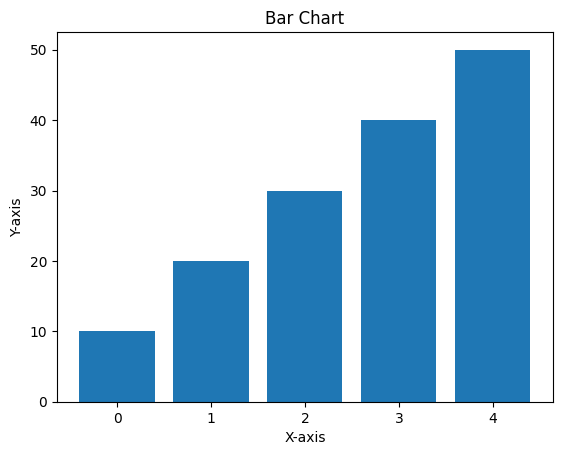

In [6]:
# @title ##Run Gemini Pro Generated Python (generally don't use exec in this manner - run in shielded process to sandbox code)
exec(code_output.replace("```", "").replace("python", ""))

In [65]:
# @title ##Example: Routing prompt based upon user input / Data Structures

#user_query = "Show me the spray chart for Mark Mcgwire in 1998 at STL" # @param {type:"string"}"
user_query = "Show me the spray chart for adolis garcia and the spray chart Jose Altuve for 2022 at New York stadium" # @param {type:"string"}"
user_query_2 = "Show me the strike zone for Jose Altuve during 2023 with shohei ohtani pitching" # @param {type:"string"}"
user_query_3 = "Show me the strike zone for Corey Seager during 2023 at TEX stadium with shohei ohtani pitching" # @param {type:"string"}"
user_query_4 = "Show me both the spray chart and the strike zone for Corey Seager during 2023 at TEX stadium with Shohei Ohtani pitching" # @param {type:"string"}"
user_query_5 = "Show me Corey Seager's batting stats for the 2023 season" # @param {type:"string"}"


#trying CO-STAR Prompt framework
global prompt_template
prompt_template = """&CONTEXT&
Analyze USER_QUERY for which functions need to be called. Each function should have it\'s parameters filled out and provided as the output in JSON format.

&OBJECTIVE&
1 - If a stadium name is in USER_QUERY, convert it to one of the following options: LAA, ATL, BAL, BOS, LAD, OAK, MIA, MIL, MIN, SFG, TBR, CIN, CLV, CSW, STL, SEA, TEX, WSN, NYY, NYM, PHI, SDP, CHC, PIT, TOR, DET, KCR, ARI.
2 - If a team name is in USER_QUERY, convert it to one of the following short name options: angels, astros, athletics, blue_jays, braves, brewers, cardinals, cubs, diamondbacks, dodgers, generic, giants, indians, mariners, marlins, mets, nationals, orioles, padres, phillies, pirates, rangers, rays, red_sox, reds, rockies, royals, tigers, twins, white_sox, or yankees.
3 - Using the USER_QUERY, determine if one or more functions need to be called
4 - For each function, attempt to extract the parameters keeping in mind the DESCRIPTION.
5 - If no data can be matched to any function, output INVALID

&STYLE&
Always use a programing style.

&TONE&
Programming.

&AUDIENCE&
The output will be passed to a python program so it must be syntactically correct and valid.

&RESPONSE&
Output only in JSON format using the provided FUNCTIONS.
If a parameter is unavailable, only use the string "Unknown".
Always use the EXAMPLE to output one or many function calls as a JSON array:

#EXAMPLE#
[
    {
        "function1": {
            "parameters": {
                "name1": "value1",
                "name2": "value2"
            }
        }
    },
    {
        "function2": {
            "parameters": {
                "name1": "value1"
            }
        }
    },
    {
        "function3": {
            "parameters": {
                "name1": "value1",
                "name2": "value2"
            }
        }
    }
]

#FUNCTIONS#
[
    {
        "get_single_player_data": {
            "parameters": {
                "player_name": "Required. A baseball players name.",
                "team_name": "Required. The short name for the baseball team. If not provided, respond with Unknown.",
                "pitcher_name": "Required. The pitcher's name, determined by using the word pitched by, pitching, or pitcher.",
                "stadium": "Required. The short name for the baseball stadium. If not explicitly provided, respond with Unknown.",
                "season": "Required. The four digit year (e.g. 1999). If not explicitly provided, respond with Unknown.",
                "chart_type": "Required. Options are spray_chart, plot_strike_zone, plot_bb_profile, plot_baseball_profile, plot_teams, batting_stats, pitching_stats, or Unknown."
                "chart_title": "Required. A title based on the chart_type for this function call."
            }
        }
    },
    {
        "comparison_request": {
            "parameters": {
                "comparison_type": "Only include if USER_QUERY asks for a comparison request. Options are bar_chart, line_chart, table, or Unknown."
            }
        }
    }
]

&USER_QUERY&
{user_query}

#Remember to use the CONTEXT, follow the OBJECTIVE, and output in the EXAMPLE format.#
"""

prompt = prompt_template.replace("{user_query}",user_query)
prompt_2 = prompt_template.replace("{user_query}",user_query_2)
prompt_3 = prompt_template.replace("{user_query}",user_query_3)
prompt_4 = prompt_template.replace("{user_query}",user_query_4)
prompt_5 = prompt_template.replace("{user_query}",user_query_5)


#print(prompt)
output = generate(prompt)

#output = bytes(output,'unicode_escape').decode('unicode_escape')
print("Prompt 1 output:")
print(output)

output = generate(prompt_2)
print("Prompt 2 output:")
print(output)

output = generate(prompt_3)
print("Prompt 3 output:")
print(output)

output = generate(prompt_4)
print("Prompt 4 output:")
print(output)

output = generate(prompt_5)
print("Prompt 5 output:")
print(output)



Prompt 1 output:
[
    {
        "get_single_player_data": {
            "parameters": {
                "player_name": "Adolis Garcia",
                "team_name": "generic",
                "pitcher_name": "Unknown",
                "stadium": "Unknown",
                "season": "2022",
                "chart_type": "spray_chart",
                "chart_title": "Spray Chart for Adolis Garcia in 2022"
            }
        }
    },
    {
        "get_single_player_data": {
            "parameters": {
                "player_name": "Jose Altuve",
                "team_name": "astros",
                "pitcher_name": "Unknown",
                "stadium": "Unknown",
                "season": "2022",
                "chart_type": "spray_chart",
                "chart_title": "Spray Chart for Jose Altuve in 2022"
            }
        }
    }
]
Prompt 2 output:
[
  {
    "get_single_player_data": {
      "parameters": {
        "player_name": "Jose Altuve",
        "team_name": "astros",

In [54]:
# @title ##Example: Asking for different charts for different players in a single query

user_query = "Show me the spray chart for Shohei Ohtani on the Angels and the strike zone for Jose Altuve on the Astros for 2021 at New York stadium" # @param {type:"string"}"
user_query = "Show me the spray chart for adolis garcia and the spray chart Jose Altuve for 2022 at New York stadium"
prompt = prompt_template.replace("{user_query}",user_query)

output = generate(prompt)
print(output)

[
    {
        "get_single_player_data": {
            "parameters": {
                "player_name": "Jose Altuve",
                "team_name": "astros",
                "pitcher_name": "Unknown",
                "stadium": "Unknown",
                "season": "2022",
                "chart_type": "spray_chart",
                "chart_title": "Jose Altuve Spray Chart for 2022"
            }
        }
    },
    {
        "get_single_player_data": {
            "parameters": {
                "player_name": "Adolis Garcia",
                "team_name": "rangers",
                "pitcher_name": "Unknown",
                "stadium": "Unknown",
                "season": "2022",
                "chart_type": "spray_chart",
                "chart_title": "Adolis Garcia Spray Chart for 2022"
            }
        }
    }
]


In [66]:
# @title ##Example: Asking for the weather

user_query = "What's the weather today?" # @param {type:"string"}"

prompt = prompt_template.replace("{user_query}",user_query)

output = generate(prompt)
print(output)

INVALID


In [69]:
# @title ##Defining Python Functions to Process Gemini Pro generated JSON output

from pybaseball import statcast_batter, spraychart, playerid_lookup, statcast_pitcher, statcast, cache
from pybaseball.plotting import plot_strike_zone, plot_bb_profile

cache.enable()

def process_json_output(json_object):
  for function in json_object:
    function_name = list(function.keys())[0]
    #print(function_name)

    if function_name == "get_single_player_data":
      function_name = "get_single_player_data"
      function = function[function_name]
      #print(function)
      player_name = bytes(function["parameters"]["player_name"], 'unicode_escape').decode('unicode_escape')
      #print(player_name)
      (first, last) = player_name.split(" ")
      player_team_name = function["parameters"]["team_name"]
      print(player_team_name)
      if (function["parameters"]["pitcher_name"] != "Unknown") and (function["parameters"]["pitcher_name"] != "None"):
        pitcher_name = bytes(function["parameters"]["pitcher_name"], 'unicode_escape').decode('unicode_escape')
        print(pitcher_name)
        (pitcher_first, pitcher_last) = pitcher_name.split(" ")
        pitcher_id_df = playerid_lookup(pitcher_last, pitcher_first, fuzzy=True)
        print("pitcher_id_df", pitcher_id_df)
        if(len(pitcher_id_df) > 1):
          yield "No exact match to '"+ function["parameters"]["pitcher_name"] + "' found, assuming first player in this list:"
          yield pitcher_id_df.to_markdown(index=False)
        pitcher_first_name = pitcher_id_df['name_first'][0]
        pitcher_last_name = pitcher_id_df['name_last'][0]
        pitcher_id = pitcher_id_df['key_mlbam'][0]
        print("pitcher_id: " + str(pitcher_id))
        pitcher_name = pitcher_first_name + " " + pitcher_last_name
      else:
        pitcher_id = "Unknown"
        pitcher_name = "Unknown"

      #print(player_team_name)
      stadium = function["parameters"]["stadium"]
      # if stadium == "Unknown":
      #   stadium = "TEX"
      # if player_team_name == "Unknown":
      #   player_team_name = "Rangers"
      #print(stadium)
      season = function["parameters"]["season"]
      #print(season)
      player_id_df = playerid_lookup(last, first, fuzzy=True)
      if(len(player_id_df) > 1):
        yield "No exact match to '"+ player_name + "' found, assuming first player in this list:"
        yield player_id_df.to_markdown(index=False)
      print( player_id_df.to_markdown(index=False))
      #print(player_id_df.to_string(index=False))
      first_name = player_id_df['name_first'][0]
      last_name = player_id_df['name_last'][0]
      player_name = first_name + " " + last_name
      #print(first_name, last_name)
      player_id = player_id_df['key_mlbam'][0]
      print("player_id: " + str(player_id))
      print("stadium: " + stadium)
      if stadium == "Unknown":
        gathering_data_for_stadium = "All Stadiums"
      else:
        gathering_data_for_stadium = stadium
      if function["parameters"]["chart_title"] is not None:
        chart_title = function["parameters"]["chart_title"]
      else:
        chart_title = "Unknown"

      print("chart_type: " + function["parameters"]["chart_type"])
      if function["parameters"]["chart_type"] == "spray_chart":
        if chart_title != "Unknown":
          title = chart_title
        else:
          title = player_name + " Spray Chart @ " + gathering_data_for_stadium + " for " + str(season)
        yield "Gathering data: " + title
        data = statcast_batter(str(season) + '-04-01', str(season) + '-10-01', player_id)

        if pitcher_id == "Unknown":
          if stadium == "Unknown":
            sub_data = data
          else:
            sub_data = data[(data['home_team'] == stadium)]
          if chart_title != "Unknown":
            title = chart_title
          else:
            title = (player_name + " Spray Chart @ " + gathering_data_for_stadium + " for " + str(season))
          if player_team_name == "Unknown":
            yield spraychart(sub_data, title = title, colorby='events')
          else:
            yield spraychart(sub_data, team_stadium = player_team_name, title = title, colorby='events')
        else:
          if stadium == "Unknown":
            sub_data = data[(data["pitcher"] == pitcher_id)]
          else:
            sub_data = data[(data['home_team'] == stadium) & (data["pitcher"] == pitcher_id)]
          if chart_title != "Unknown":
            title = chart_title
          else:
            title = (player_name + " Spray Chart against " + pitcher_name + " @ " + gathering_data_for_stadium + " for " + str(season))
          yield spraychart(sub_data, team_stadium = player_team_name, title = title, colorby='events')

      if function["parameters"]["chart_type"] == "plot_strike_zone":
        if chart_title != "Unknown":
          title = chart_title
        else:
          title = player_name + " Strikezone @ " + gathering_data_for_stadium + " for " + str(season)
        yield "Gathering data: " + title
        all_data = statcast(str(season) + "-04-01", str(season) + "-10-01")

        if pitcher_id == "Unknown" and stadium == "Unknown":
          yield plot_strike_zone(all_data.loc[(all_data["batter"] == player_id)], title = title, colorby='events')
        elif pitcher_id == "Unknown" and stadium != "Unknown":
          yield plot_strike_zone(all_data.loc[(all_data["batter"] == player_id) & (all_data["home_team"] == stadium)], title = title, colorby='events')
        elif pitcher_id != "Unknown" and stadium == "Unknown":
          yield plot_strike_zone(all_data.loc[(all_data["batter"] == player_id) & (all_data["pitcher"] == pitcher_id)], title = title, colorby='events')
        else:
          yield plot_strike_zone(all_data.loc[(all_data["batter"] == player_id) & (all_data["home_team"] == stadium) & (all_data["pitcher"] == pitcher_id)], title = title, colorby='events')

      if function["parameters"]["chart_type"] == "plot_bb_profile" or function["parameters"]["chart_type"] == "plot_baseball_profile":
        if chart_title != "Unknown":
          title = chart_title
        else:
          title = player_name + " Baseball Profile @ " + gathering_data_for_stadium + " for " + str(season)
        yield "Gathering data: " + title
        all_data = statcast(str(season) + "-04-01", str(season) + "-10-01")
        if pitcher_id == "Unknown":
          yield plot_bb_profile(all_data.loc[(all_data["batter"] == player_id) & (all_data["home_team"] == stadium)])
        else:
          yield plot_bb_profile(all_data.loc[(all_data["batter"] == player_id) & (all_data["home_team"] == stadium) & (all_data["pitcher"] == pitcher_id)])

      if function["parameters"]["chart_type"] == "batting_stats":
        if chart_title != "Unknown":
          title = chart_title
        else:
          title = player_name + " Baseball Stats for " + str(season)
        yield "Gathering data: " + title
        statcast_stats_df = statcast_batter(str(season) + "-04-01", str(season) + "-10-01", player_id)
        yield statcast_stats_df.to_markdown(index=False)


      if function["parameters"]["chart_type"] == "pitching_stats":
        if chart_title != "Unknown":
          title = chart_title
        else:
          title = player_name + " Pitching Stats for " + str(season)
        yield "Gathering data: " + title
        statcast_stats_df = statcast_pitcher(str(season) + "-04-01", str(season) + "-10-01", player_id)
        yield statcast_stats_df.to_markdown(index=False)


      # if function["parameters"]["chart_type"] == "batting_stats" or function["parameters"]["chart_type"] == "pitching_stats":
      #   # print(statcast_stats_df)
      #   yield statcast_stats_df.to_markdown(index=False)


    elif function_name == "comparison_request":
      function_name = "comparison_request"
      function = function[function_name]
      #print(function)
      comparison_type = function["parameters"]["comparison_type"]
      yield "Comparisons are not currently implemented."
      print(comparison_type)
  #final return from function
  return

import json

try:
  functions = json.loads(output.replace("```JSON","").replace("```",""))
  print(functions)
  json_object = functions

  for value in process_json_output(functions):
    value
    print(value, " : ",str(type(value)))
except:
  if output == "INVALID":
    print("LLM returned an invalid response of: '"+output+"'")

LLM returned an invalid response of: 'INVALID'


In [ ]:
# @title ## Get Avatar for Chatbot

!pip install --upgrade CairoSVG

from PIL import Image
import cairosvg

cairosvg.svg2png(url="https://baseballsavant.mlb.com/site-core/images/savant-logo.svg", write_to="avatar.png")
display(Image.open("avatar.png"))

In [12]:
# @title ## Setup Temp dir for images
!rm -rf /content/chatbot_images || true
!mkdir -p /content/chatbot_images
images_dir = "/content/chatbot_images/"

In [70]:
# @title ## Initialize & Run Gradio

import gradio as gr
import pandas as pd
import time, os, uuid

def print_like_dislike(x: gr.LikeData):
    print(x.index, x.value, x.liked)


def add_text(history, text):
    history = history + [(text, None)]
    return history, gr.Textbox(value="", interactive=False)


def bot(history):
    # to add a bot msg response - it goes into the second tuple (user is first) in a history element
    # media can be added by providing a filename
    #history[-1][1] = ("avatar.png",)
    user_query = history[-1][0]
    print(user_query)
    prompt = prompt_template.replace("{user_query}",user_query)
    print("---")
    print(prompt)
    print("---")
    output = generate(prompt)
    print(output)
    try:
      functions = json.loads(output.replace("```JSON","").replace("```",""))
    except:
      if output == "INVALID":
        print("LLM returned an invalid response of: '"+output+"'")
      value = "Sorry, that's not a request I can help with."
      history = history + [(None, value)]
      yield history
      return history

    for value in process_json_output(functions):
      print(str(type(value)))
      if str(type(value)) == "<class 'str'>":
        history = history + [(None, value)]
      elif str(type(value)) == "<class 'pandas.core.frame.DataFrame'>":
        history = history + [(None, str(value))]
      elif str(type(value)) == "<class 'matplotlib.axes._axes.Axes'>":
        value_filename = images_dir+uuid.uuid4().hex+".png"
        value.get_figure().savefig(value_filename)
        history = history + [(None, (value_filename,))]
      yield history
    return history

css = """
.container {
    height: 160vh;
}
"""

with gr.Blocks(css=css) as demo:
  with gr.Column():
    chatbot = gr.Chatbot(
        [],
        #elem_classes=["container"],
        height=500,
        elem_id="chatbot",
        bubble_full_width=False,
        avatar_images=(None, (os.path.join(os.path.dirname("."), "avatar.png"))),
        )

    with gr.Row():
        txt = gr.Textbox(
            #scale=1,
            show_label=False,
            placeholder="Enter a query to request a stat chart for a player (spray_chart, plot_strike_zone, plot_bb_profile, batting_stats, or pitching_stats)",
            container=False,
        )
        gr.Examples(examples=[
              ["""Show me the strike zone for Jose Altuve during 2023 with shohei ohtani pitching"""],
              ["""Show me the strike zone for Corey Seager during 2023 at TEX stadium with shohei ohtani pitching"""],
              ["""Show me the spray chart for adolis garcia and the spray chart Jose Altuve for 2022 at New York stadium"""],
              ["""What's the weather?"""],
                        ],
                inputs=txt)

  txt_msg = txt.submit(add_text, [chatbot, txt], [chatbot, txt], queue=False).then(
      bot, chatbot, chatbot, api_name="bot_response"
  )
  txt_msg.then(lambda:
               gr.Textbox(interactive=True), None, [txt], queue=False
               )

  chatbot.like(print_like_dislike, None, None)


demo.queue()
demo.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://56a38f58a68f069791.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Show me the spray chart for adolis garcia and the spray chart Jose Altuve for 2022 at New York stadium
---
&CONTEXT&
Analyze USER_QUERY for which functions need to be called. Each function should have it's parameters filled out and provided as the output in JSON format.

&OBJECTIVE&
1 - If a stadium name is in USER_QUERY, convert it to one of the following options: LAA, ATL, BAL, BOS, LAD, OAK, MIA, MIL, MIN, SFG, TBR, CIN, CLV, CSW, STL, SEA, TEX, WSN, NYY, NYM, PHI, SDP, CHC, PIT, TOR, DET, KCR, ARI.
2 - If a team name is in USER_QUERY, convert it to one of the following short name options: angels, astros, athletics, blue_jays, braves, brewers, cardinals, cubs, diamondbacks, dodgers, generic, giants, indians, mariners, marlins, mets, nationals, orioles, padres, phillies, pirates, rangers, rays, red_sox, reds, rockies, royals, tigers, twins, white_sox, or yankees.
3 - Using the USER_QUERY, determine if one or more functions need to be called
4 - For each function, attempt to extract t

/usr/local/lib/python3.10/dist-packages/pybaseball/plotting.py:138: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]


<class 'matplotlib.axes._axes.Axes'>
astros
No identically matched names found! Returning the 5 most similar names.
<class 'str'>
<class 'str'>
| name_last   | name_first   |   key_mlbam | key_retro   | key_bbref   |   key_fangraphs |   mlb_played_first |   mlb_played_last |
|:------------|:-------------|------------:|:------------|:------------|----------------:|-------------------:|------------------:|
| altuve      | josé         |      514888 | altuj001    | altuvjo01   |            5417 |               2011 |              2023 |
| pate        | joe          |      120278 | patej101    | patejo01    |         1010051 |               1926 |              1927 |
| neale       | joe          |      119678 | nealj102    | nealejo01   |         1009475 |               1886 |              1891 |
| mauer       | joe          |      408045 | mauej001    | mauerjo01   |            1857 |               2004 |              2018 |
| lucey       | joe          |      117979 | lucej101    | lucey

/usr/local/lib/python3.10/dist-packages/pybaseball/plotting.py:138: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]


<class 'matplotlib.axes._axes.Axes'>
<class 'str'>
bar_chart
What's the weather?
---
&CONTEXT&
Analyze USER_QUERY for which functions need to be called. Each function should have it's parameters filled out and provided as the output in JSON format.

&OBJECTIVE&
1 - If a stadium name is in USER_QUERY, convert it to one of the following options: LAA, ATL, BAL, BOS, LAD, OAK, MIA, MIL, MIN, SFG, TBR, CIN, CLV, CSW, STL, SEA, TEX, WSN, NYY, NYM, PHI, SDP, CHC, PIT, TOR, DET, KCR, ARI.
2 - If a team name is in USER_QUERY, convert it to one of the following short name options: angels, astros, athletics, blue_jays, braves, brewers, cardinals, cubs, diamondbacks, dodgers, generic, giants, indians, mariners, marlins, mets, nationals, orioles, padres, phillies, pirates, rangers, rays, red_sox, reds, rockies, royals, tigers, twins, white_sox, or yankees.
3 - Using the USER_QUERY, determine if one or more functions need to be called
4 - For each function, attempt to extract the parameters keeping 

100%|██████████| 184/184 [00:21<00:00,  8.52it/s]


<class 'matplotlib.axes._axes.Axes'>
Show me the strike zone for Corey Seager during 2023 at TEX stadium with shohei ohtani pitching
---
&CONTEXT&
Analyze USER_QUERY for which functions need to be called. Each function should have it's parameters filled out and provided as the output in JSON format.

&OBJECTIVE&
1 - If a stadium name is in USER_QUERY, convert it to one of the following options: LAA, ATL, BAL, BOS, LAD, OAK, MIA, MIL, MIN, SFG, TBR, CIN, CLV, CSW, STL, SEA, TEX, WSN, NYY, NYM, PHI, SDP, CHC, PIT, TOR, DET, KCR, ARI.
2 - If a team name is in USER_QUERY, convert it to one of the following short name options: angels, astros, athletics, blue_jays, braves, brewers, cardinals, cubs, diamondbacks, dodgers, generic, giants, indians, mariners, marlins, mets, nationals, orioles, padres, phillies, pirates, rangers, rays, red_sox, reds, rockies, royals, tigers, twins, white_sox, or yankees.
3 - Using the USER_QUERY, determine if one or more functions need to be called
4 - For each 

100%|██████████| 184/184 [00:23<00:00,  7.93it/s]


<class 'matplotlib.axes._axes.Axes'>
Show me the spray chart for adolis garcia and the spray chart Jose Altuve for 2022 at New York stadium
---
&CONTEXT&
Analyze USER_QUERY for which functions need to be called. Each function should have it's parameters filled out and provided as the output in JSON format.

&OBJECTIVE&
1 - If a stadium name is in USER_QUERY, convert it to one of the following options: LAA, ATL, BAL, BOS, LAD, OAK, MIA, MIL, MIN, SFG, TBR, CIN, CLV, CSW, STL, SEA, TEX, WSN, NYY, NYM, PHI, SDP, CHC, PIT, TOR, DET, KCR, ARI.
2 - If a team name is in USER_QUERY, convert it to one of the following short name options: angels, astros, athletics, blue_jays, braves, brewers, cardinals, cubs, diamondbacks, dodgers, generic, giants, indians, mariners, marlins, mets, nationals, orioles, padres, phillies, pirates, rangers, rays, red_sox, reds, rockies, royals, tigers, twins, white_sox, or yankees.
3 - Using the USER_QUERY, determine if one or more functions need to be called
4 - Fo

/usr/local/lib/python3.10/dist-packages/pybaseball/plotting.py:138: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]


<class 'matplotlib.axes._axes.Axes'>
astros
No identically matched names found! Returning the 5 most similar names.
<class 'str'>
<class 'str'>
| name_last   | name_first   |   key_mlbam | key_retro   | key_bbref   |   key_fangraphs |   mlb_played_first |   mlb_played_last |
|:------------|:-------------|------------:|:------------|:------------|----------------:|-------------------:|------------------:|
| altuve      | josé         |      514888 | altuj001    | altuvjo01   |            5417 |               2011 |              2023 |
| pate        | joe          |      120278 | patej101    | patejo01    |         1010051 |               1926 |              1927 |
| neale       | joe          |      119678 | nealj102    | nealejo01   |         1009475 |               1886 |              1891 |
| mauer       | joe          |      408045 | mauej001    | mauerjo01   |            1857 |               2004 |              2018 |
| lucey       | joe          |      117979 | lucej101    | lucey

/usr/local/lib/python3.10/dist-packages/pybaseball/plotting.py:138: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]


<class 'matplotlib.axes._axes.Axes'>
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://56a38f58a68f069791.gradio.live
